В прошлый раз мы уже использовали Azure ML чтобы обучать простенькие модели. В этот раз более агрессивно задействуем этот инструмент и будет обучать нейронные сети.

Подключаем Azure CLI

In [ ]:
! sudo apt-get update && sudo apt-get install curl -y
! pip install azureml-sdk[notebooks,automl] --ignore-installed
! curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash
! az extension add -n azure-cli-ml

In [ ]:
! az login

Создаем новый воркспейс

In [ ]:
! az ml workspace create -w ml-workspace-2 -g hadoop2 --sku enterprise

In [ ]:
import azureml.core
from azureml.core.workspace import Workspace
ws = Workspace.get(
     name = "ml-workspace-2",
     subscription_id = "ddb191b9-4c87-419a-ab15-ed1e8a3999c2",
     resource_group = 'hadoop2')

In [4]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name='experiment-1')

Создаем кластер с машинами с GPU. Выделим сразу 3 ноды для работы.

In [5]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           min_nodes=3, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True, timeout_in_minutes=20)

Creating a new compute target...
Creating
Succeeded.....................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


Создадим рабочую директорию для первого эксперимента. Попробуем сконструировать простенькую архитектуру для мниста и обучить ее на CPU на одной машине.

In [6]:
! mkdir -p keras

In [14]:
%%writefile keras/train.py

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import glob
import time

from azureml.core import Run

# ------------------------  Входные параметры

parser = argparse.ArgumentParser()
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--learning-rate', type=float, dest='learning_rate', default=0.001, help='learning rate')
parser.add_argument('--epochs', type=int, dest='epochs', default=5, help='number of epochs')

args = parser.parse_args()

n_epochs = args.epochs
batch_size = args.batch_size
learning_rate = args.learning_rate

# --------------------------- Обработка данных для обучения

num_classes = 10

img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# ------------------------------ Построение модели

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=RMSprop(lr=learning_rate),
              metrics=['accuracy'])

# ---------------------------- Обучение модели

start = time.time()

run = Run.get_context()

class LogRunMetrics(Callback):
    def on_epoch_end(self, epoch, log):
        run.log('Loss', log['loss'])
        run.log('Accuracy', log['acc'])

callbacks = [
    LogRunMetrics()
]

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              callbacks=callbacks,
              epochs=n_epochs,
              verbose=2,
              validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

end = time.time()

run.log("Final test loss", score[0])
print('Test loss:', score[0])

run.log('Final test accuracy', score[1])
print('Test accuracy:', score[1])

time_delta = end - start
run.log('Elapsed time', time_delta)
print('Elapsed time', time_delta)


plt.figure(figsize=(6, 3))
plt.title('MNIST with Keras MLP ({} epochs)'.format(n_epochs), fontsize=14)
plt.plot(history.history['acc'], 'b-', label='Accuracy', lw=4, alpha=0.5)
plt.plot(history.history['loss'], 'r--', label='Loss', lw=4, alpha=0.5)
plt.legend(fontsize=12)
plt.grid(True)

# log an image
run.log_image('Accuracy vs Loss', plot=plt)

# -------------------------------- Сохранение модели

os.makedirs('./outputs/model', exist_ok=True)

model_json = model.to_json()
with open('./outputs/model/model.json', 'w') as f:
    f.write(model_json)

model.save_weights('./outputs/model/model.h5')
print("model saved in ./outputs/model folder")

Overwriting keras/train.py


Мы используем Keras как надстройку над Tensorflow, поэтому будем создадим блок обучения с TF

In [ ]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--batch-size': 50,
    '--learning-rate': 0.001,
    '--epochs': 5
}

est = TensorFlow(source_directory='keras',
                 script_params=script_params,
                 compute_target=compute_target, 
                 entry_script='train.py', 
                 pip_packages=['keras==2.2.5','azureml-dataprep[pandas,fuse]','matplotlib'])

Запускаем эксперимент

In [ ]:
run = experiment.submit(est)
run.wait_for_completion(show_output = True)

После успешного завершения, регистрируем полученную модель.

Для нашей модели нам потребуется написать собственный скрипт, который будет расчитывать предикт. 

В этом скрипте необходимо указать две функции - `init` и `run`. Первая будет запущена один раз при старте, вторая - каждый раз при вызове.

In [17]:
model = run.register_model(model_name='keras-mnist', model_path='outputs/model')

In [18]:
%%writefile keras/score.py
import json
import numpy as np
import os
from keras.models import model_from_json

from azureml.core.model import Model

def init():
    global model
    model_root = Model.get_model_path('keras-mnist')
    with open(os.path.join(model_root, 'model.json'), 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    y_hat = np.argmax(model.predict(data), axis=1)
    return y_hat.tolist()

Overwriting keras/score.py


Для выгрузки также потребуется указать дополнительные библиотеки, которые необходимо будет поставить

In [73]:
%%writefile keras/requirements.txt

keras==2.2.5
astor==0.8.1
tensorflow==1.12
azureml-defaults

Overwriting req.txt


In [76]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model
from azureml.core.environment import Environment


myenv = Environment.from_pip_requirements(name="mypipenv", file_path='keras/requirements.txt')
inference_config = InferenceConfig(entry_script="keras/score.py", environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,
                                               auth_enabled=False,
                                               memory_gb=1,
                                               tags={'name': 'mnist', 'framework': 'Keras'},
                                               description='Keras on MNIST')

service = Model.deploy(workspace=ws, 
                           name='keras-mnist-svc', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)

service.wait_for_deployment(True)
print(service.state)

Running.........................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [78]:
print(service.scoring_uri)

http://f8451e29-45c6-41d8-96da-55ea93dced8e.westus2.azurecontainer.io/score


Проверим работу сервиса. Выгиузим 3 случайные картинки из мниста

In [83]:
%%writefile mnist_5.svm
5 153:3 154:18 155:18 156:18 157:126 158:136 159:175 160:26 161:166 162:255 163:247 164:127 177:30 178:36 179:94 180:154 181:170 182:253 183:253 184:253 185:253 186:253 187:225 188:172 189:253 190:242 191:195 192:64 204:49 205:238 206:253 207:253 208:253 209:253 210:253 211:253 212:253 213:253 214:251 215:93 216:82 217:82 218:56 219:39 232:18 233:219 234:253 235:253 236:253 237:253 238:253 239:198 240:182 241:247 242:241 261:80 262:156 263:107 264:253 265:253 266:205 267:11 269:43 270:154 290:14 291:1 292:154 293:253 294:90 320:139 321:253 322:190 323:2 348:11 349:190 350:253 351:70 377:35 378:241 379:225 380:160 381:108 382:1 406:81 407:240 408:253 409:253 410:119 411:25 435:45 436:186 437:253 438:253 439:150 440:27 464:16 465:93 466:252 467:253 468:187 494:249 495:253 496:249 497:64 519:46 520:130 521:183 522:253 523:253 524:207 525:2 545:39 546:148 547:229 548:253 549:253 550:253 551:250 552:182 571:24 572:114 573:221 574:253 575:253 576:253 577:253 578:201 579:78 597:23 598:66 599:213 600:253 601:253 602:253 603:253 604:198 605:81 606:2 623:18 624:171 625:219 626:253 627:253 628:253 629:253 630:195 631:80 632:9 649:55 650:172 651:226 652:253 653:253 654:253 655:253 656:244 657:133 658:11 677:136 678:253 679:253 680:253 681:212 682:135 683:132 684:16
0 128:51 129:159 130:253 131:159 132:50 155:48 156:238 157:252 158:252 159:252 160:237 182:54 183:227 184:253 185:252 186:239 187:233 188:252 189:57 190:6 208:10 209:60 210:224 211:252 212:253 213:252 214:202 215:84 216:252 217:253 218:122 236:163 237:252 238:252 239:252 240:253 241:252 242:252 243:96 244:189 245:253 246:167 263:51 264:238 265:253 266:253 267:190 268:114 269:253 270:228 271:47 272:79 273:255 274:168 290:48 291:238 292:252 293:252 294:179 295:12 296:75 297:121 298:21 301:253 302:243 303:50 317:38 318:165 319:253 320:233 321:208 322:84 329:253 330:252 331:165 344:7 345:178 346:252 347:240 348:71 349:19 350:28 357:253 358:252 359:195 372:57 373:252 374:252 375:63 385:253 386:252 387:195 400:198 401:253 402:190 413:255 414:253 415:196 427:76 428:246 429:252 430:112 441:253 442:252 443:148 455:85 456:252 457:230 458:25 467:7 468:135 469:253 470:186 471:12 483:85 484:252 485:223 494:7 495:131 496:252 497:225 498:71 511:85 512:252 513:145 521:48 522:165 523:252 524:173 539:86 540:253 541:225 548:114 549:238 550:253 551:162 567:85 568:252 569:249 570:146 571:48 572:29 573:85 574:178 575:225 576:253 577:223 578:167 579:56 595:85 596:252 597:252 598:252 599:229 600:215 601:252 602:252 603:252 604:196 605:130 623:28 624:199 625:252 626:252 627:253 628:252 629:252 630:233 631:145 652:25 653:128 654:252 655:253 656:252 657:141 658:37
4 161:67 162:232 163:39 173:62 174:81 189:120 190:180 191:39 201:126 202:163 216:2 217:153 218:210 219:40 229:220 230:163 244:27 245:254 246:162 257:222 258:163 272:183 273:254 274:125 284:46 285:245 286:163 300:198 301:254 302:56 312:120 313:254 314:163 327:23 328:231 329:254 330:29 340:159 341:254 342:120 355:163 356:254 357:216 358:16 368:159 369:254 370:67 380:14 381:86 382:178 383:248 384:254 385:91 396:159 397:254 398:85 402:47 403:49 404:116 405:144 406:150 407:241 408:243 409:234 410:179 411:241 412:252 413:40 424:150 425:253 426:237 427:207 428:207 429:207 430:253 431:254 432:250 433:240 434:198 435:143 436:91 437:28 438:5 439:233 440:250 453:119 454:177 455:177 456:177 457:177 458:177 459:98 460:56 466:102 467:254 468:220 494:169 495:254 496:137 522:169 523:254 524:57 550:169 551:254 552:57 578:169 579:255 580:94 606:169 607:254 608:96 634:169 635:254 636:153 662:169 663:255 664:153 690:96 691:254 692:153

Overwriting mnist_5.svm


In [105]:
%matplotlib inline
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import requests
import json
import numpy as np

In [106]:
X, y = load_svmlight_file('mnist_5.svm', n_features=784)
X = X / 255

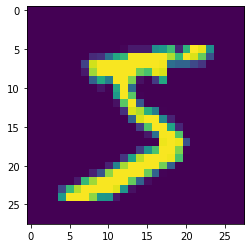

In [107]:
plt.imshow(X[0].reshape(28, 28).toarray())

In [108]:
r_data = [X[0].toarray().reshape(28, 28, 1).tolist()]

r = requests.post(service.scoring_uri, json={
    'method': 'predict',
    'data': r_data
})
print(r.json())

[5]


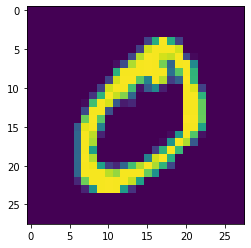

In [109]:
plt.imshow(X[1].reshape(28, 28).toarray())

In [110]:
r_data = [X[1].toarray().reshape(28, 28, 1).tolist()]

r = requests.post(service.scoring_uri, json={
    'method': 'predict',
    'data': r_data
})
print(r.json())

[0]


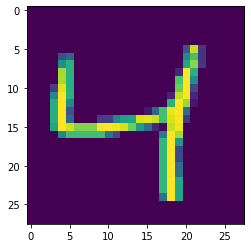

In [111]:
plt.imshow(X[2].reshape(28, 28).toarray())

In [112]:
r_data = [X[2].toarray().reshape(28, 28, 1).tolist()]

r = requests.post(service.scoring_uri, json={
    'method': 'predict',
    'data': r_data
})
print(r.json())

[4]


Попробуем теперь обучить эту же модель, но на GPU. Для этого не потребуется никаким образом менять наш код - просто укажем, что текущий train нужно будет запускать и использованием GPU

In [ ]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--batch-size': 50,
    '--learning-rate': 0.001,
    '--epochs': 20
}

est = TensorFlow(source_directory='keras',
                 script_params=script_params,
                 compute_target=compute_target, 
                 entry_script='train.py', 
                 pip_packages=['keras==2.2.5','azureml-dataprep[pandas,fuse]','matplotlib'],
                 use_gpu=True)

In [ ]:
run = experiment.submit(est)
run.wait_for_completion(show_output = True)

Итого:
* 5 эпох на CPU - 244 секунды
* 20 эпох на GPU - 221 секунда

Попробуем обучить машину на GPU распределенно через Horovod. Для этого уже потребуется немного видоизменить наш код, явно добавив использоваение инструмента Horovod. Развертывание необходимой инфраструктуры для запуска берет на себя Azure.

In [123]:
! mkdir -p keras-distributed/

In [127]:
%%writefile keras-distributed/train.py
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import Callback
from keras import backend as K
import math
import tensorflow as tf
import horovod.keras as hvd
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import glob
import time

from azureml.core import Run

# ------------------------ 

parser = argparse.ArgumentParser()
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--epochs', type=int, dest='epochs', default=5, help='number of epochs')

args = parser.parse_args()

n_epochs = args.epochs
batch_size = args.batch_size
num_classes = 10

# -----------------------------

# Horovod: initialize Horovod.
hvd.init()

# Horovod: pin GPU to be used to process local rank (one GPU per process)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = str(hvd.local_rank())
K.set_session(tf.Session(config=config))

# Horovod: adjust number of epochs based on number of GPUs.
epochs = int(math.ceil(n_epochs / hvd.size()))

# Input image dimensions
img_rows, img_cols = 28, 28

# The data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# ---------------------------------------

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Horovod: adjust learning rate based on number of GPUs.
opt = keras.optimizers.Adadelta(1.0 * hvd.size())

# Horovod: add Horovod Distributed Optimizer.
opt = hvd.DistributedOptimizer(opt)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# ------------------------------------------

run = Run.get_context()

class LogRunMetrics(Callback):
    def on_epoch_end(self, epoch, log):
        run.log('Loss', log['loss'])
        run.log('Accuracy', log['acc'])

callbacks = [
    # Horovod: broadcast initial variable states from rank 0 to all other processes.
    # This is necessary to ensure consistent initialization of all workers when
    # training is started with random weights or restored from a checkpoint.
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),
    LogRunMetrics()
]

# -------------------------------------------

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          callbacks=callbacks,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

if hvd.rank() == 0:

    run.log("Final test loss", score[0])
    print('Test loss:', score[0])

    run.log('Final test accuracy', score[1])
    print('Test accuracy:', score[1])

    plt.figure(figsize=(6, 3))
    plt.title('MNIST with Keras MLP ({} epochs)'.format(n_epochs), fontsize=14)
    plt.plot(history.history['acc'], 'b-', label='Accuracy', lw=4, alpha=0.5)
    plt.plot(history.history['loss'], 'r--', label='Loss', lw=4, alpha=0.5)
    plt.legend(fontsize=12)
    plt.grid(True)

    # log an image
    run.log_image('Accuracy vs Loss', plot=plt)

    os.makedirs('./outputs/model', exist_ok=True)

    model_json = model.to_json()
    with open('./outputs/model/model.json', 'w') as f:
        f.write(model_json)

    model.save_weights('./outputs/model/model.h5')
    print("model saved in ./outputs/model folder")
    

Overwriting keras-distributed/train.py


In [125]:
from azureml.train.dnn import TensorFlow, Mpi

script_params = {
    '--batch-size': 128,
    '--epochs': 20
}

est = TensorFlow(source_directory='keras-distributed',
                 script_params=script_params,
                 compute_target=compute_target, 
                 entry_script='train.py', 
                 pip_packages=['keras==2.2.5','azureml-dataprep[pandas,fuse]','matplotlib'],
                 node_count=3,
                 distributed_training=Mpi(),
                 framework_version='1.13', 
                 use_gpu=True,
                )

In [ ]:
run = experiment.submit(est)
run.wait_for_completion(show_output = True)

**Задача**:
* Замерить время обучения распределенного Кераса и сравнить его с временем обучения предыдущих двух моделей
* (Задача на доп. балл). Распределенно обучить сетку на гигантском мнисте - https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/mnist8m.bz2 (с этим датасетом мы уже работали на 6 семинаре). Замерить скорость обучения такой модели.